### 1. Instantiate GPU & Load Dataset


In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train_dataset_medical.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='validation_dataset_medical.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

### Accelerator

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [ ]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [ ]:
os.environ["HF_TOKEN"] = " "

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

### 3. Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

6


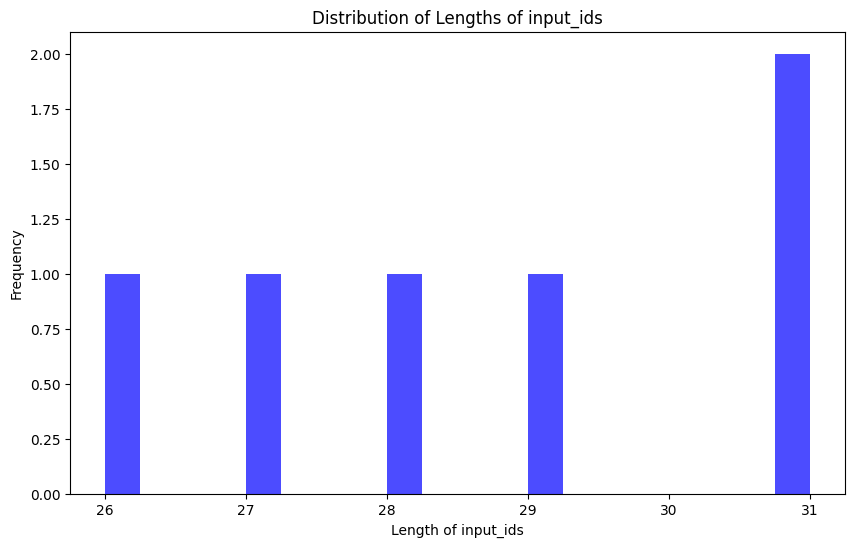

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [ ]:
max_length = 28 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 1, 774, 22478, 28747, 1824, 10110, 10272, 28804, 13, 774, 26307, 28747, 12830, 1179, 2996, 28808, 320, 5549, 349, 9741, 477, 2739, 1856, 19010, 3946, 2]


Now all the samples should be the same length, `max_length`.

6


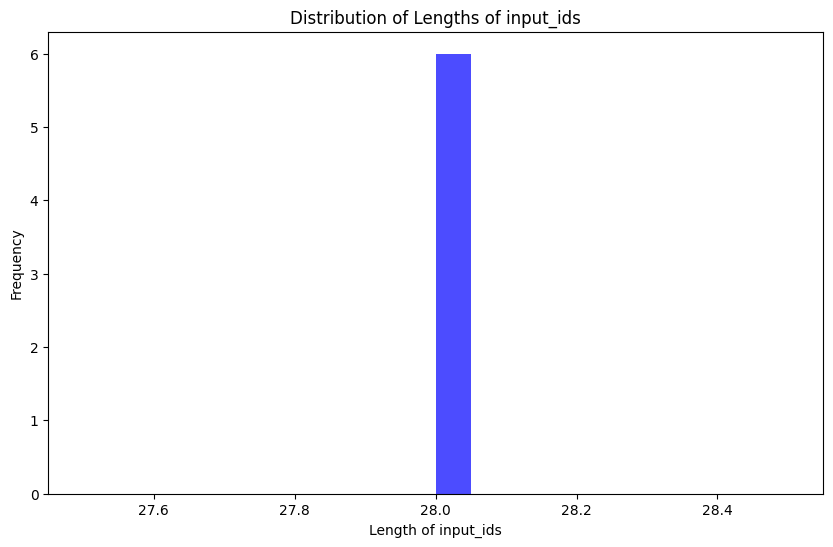

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

Optionally, you can check how Mistral does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

In [ ]:
eval_prompt = """ What is an eraser?"""

The `eval_prompt` I used was:

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 What is an eraser?
An eraser is a tool used to remove or correct pencil marks on paper. It is typically made of rubber, but other materials like plastic, vinyl, or graphite can also be used. The main function of an eraser is to lift the graphite particles off the paper when it comes into contact with them, leaving behind a clean surface for writing or drawing again.

History of Erasers:
The earliest known use of an erasing material was around 1500 AD in Europe when artists used bread crumbs or bread itself to wipe away mistakes while painting. However, this method was not practical for written work as it left residue and smudged the paper. In the late 16th century, Italian artist Annibale Carracci discovered that the sap from certain trees could be used as an effective eraser. He would collect the sap from the tree and let it dry before using it to rub out mistakes on his drawings. This method remained popular among artists until the early 19th century when rubber erasers were invente

Observe how the model does out of the box.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

### 5. Run Training!

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=100,              #steps to train
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=False,
        optim="paged_adamw_8bit",
        logging_steps=10,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=10,                # Save checkpoints every 10 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=10,               # Evaluate and save checkpoints every 10 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


wandb: Currently logged in as: daisyko (peculab). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
10,3.828000,2.172941
20,0.732500,2.001353
30,0.402800,2.170609
40,0.323300,2.057231
50,0.271400,1.966642
60,0.218600,2.030459
70,0.181300,2.096401
80,0.149200,2.132070
90,0.119700,2.159106
100,0.126400,2.125866


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=100, training_loss=0.6353281712532044, metrics={'train_runtime': 283.9741, 'train_samples_per_second': 0.704, 'train_steps_per_second': 0.352, 'total_flos': 181331671449600.0, 'train_loss': 0.6353281712532044, 'epoch': 50.0})

### 6. Try the Trained Model



In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-90")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [ ]:
eval_prompt = " What is an eraser? "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 What is an eraser?  Well, an eraser is not really an eraser. It's a rubber thingy on the @ @#! end of a pencil or pen for correcting mistakes!!!!! Or at least that's what it used to be!!!!!! But now $%&@!!!!! Erasers are made out of pink stupid plastic $%^& $%$#!!!!!!!!! And they don't work!!!!!!!!!!!!! They just sm @ # !!!!!! The damn


In [ ]:
eval_prompt = " What is a pencil? "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 What is a pencil?  Holy good question! Pencil is damn writing tool!!!!!!!!!
 #################################################

 # Question: What is the full form of HTML and CSS ???????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????
